# Env setup

In [2]:
!nvidia-smi

Tue Oct 28 14:26:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.29                 Driver Version: 581.29         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   43C    P0             33W /  200W |    1096MiB /  12282MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# !pip uninstall torch torchvision torchaudio -y
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
# !pip install -q diffusers transformers huggingface-hub accelerate laion-clap librosa torch torchvision torchaudio Pillow
# !pip install matplotlib

# 1. Imports and Device Setup

In [7]:
# ---- Setup & Imports ----
import os
import numpy as np
import torch
import torchaudio
import torchvision
import librosa
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image

from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from laion_clap import CLAP_Module
from transformers import CLIPProcessor, CLIPModel

# ---- Device setup ----
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Environment ready — using device: {DEVICE}")


✅ Environment ready — using device: cuda


# 2. Basic folder structure setup

In [8]:
# ---- Dataset Path Setup ----
AUDIO_DIR = "extracted_audiocaps"

if not os.path.exists(AUDIO_DIR):
    raise FileNotFoundError(f"❌ Folder not found: {AUDIO_DIR}")

print(f"📂 Using dataset folder: {AUDIO_DIR}")


📂 Using dataset folder: extracted_audiocaps


# 3. Load CLAP Model (Audio encoder baseline)

In [9]:
# ---- Load CLAP + Stable Diffusion ----
from transformers import ClapModel, ClapProcessor
from diffusers import StableDiffusionPipeline

print(f"🚀 Using device: {DEVICE}")

# 1️⃣ CLAP (Audio-Text Encoder)
print("🎧 Loading CLAP model...")
clap_model = ClapModel.from_pretrained("laion/clap-htsat-unfused").to(DEVICE)
clap_processor = ClapProcessor.from_pretrained("laion/clap-htsat-unfused")
clap_model.eval()

# 2️⃣ Stable Diffusion (optional heavy model)
print("🎨 Loading Stable Diffusion v1.5...")
sd_pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16 if DEVICE.type == "cuda" else torch.float32
).to(DEVICE)
# Optional VRAM savers:
sd_pipe.enable_attention_slicing()
sd_pipe.enable_vae_slicing()
# sd_pipe.enable_model_cpu_offload()  # if < 8 GB VRAM

# 3️⃣ Freeze CLAP
for p in clap_model.parameters():
    p.requires_grad = False

print("✅ Models loaded successfully and ready for inference!")


🚀 Using device: cuda
🎧 Loading CLAP model...
🎨 Loading Stable Diffusion v1.5...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


✅ Models loaded successfully and ready for inference!


# 4. Test Audio Embedding Extration

In [12]:
# ---- Test: CLAP Audio & Text Embedding Extraction ----
from tqdm import tqdm

AUDIO_DIR = "extracted_audiocaps"
CAPTIONS_PATH = os.path.join(AUDIO_DIR, "captions.txt")

# Load caption–audio pairs
pairs = []
with open(CAPTIONS_PATH, "r", encoding="utf-8") as f:
    for line in f:
        if line.strip():
            fname, caption = line.strip().split("\t", 1)
            pairs.append((fname, caption))
print(f"Loaded {len(pairs)} audio–caption pairs")

audio_embs, text_embs = [], []

# Test only first few for now
for fname, caption in tqdm(pairs[:10], desc="Extracting embeddings"):
    audio_path = os.path.join(AUDIO_DIR, fname)

    # ---- Audio ----
    audio, sr = librosa.load(audio_path, sr=48000)
    audio_inputs = clap_processor(audio=audio, return_tensors="pt", sampling_rate=48000).to(DEVICE)
    with torch.no_grad():
        audio_feat = clap_model.get_audio_features(**audio_inputs)
    audio_embs.append(audio_feat.cpu())

    # ---- Text ----
    text_inputs = clap_processor(text=[caption], return_tensors="pt", padding=True).to(DEVICE)
    with torch.no_grad():
        text_feat = clap_model.get_text_features(**text_inputs)
    text_embs.append(text_feat.cpu())

audio_embs = torch.cat(audio_embs)
text_embs = torch.cat(text_embs)

print("")
print(f"Audio embeddings: {audio_embs.shape}")
print(f"Text embeddings: {text_embs.shape}")

# Optional: check semantic similarity
sim = torch.nn.functional.cosine_similarity(audio_embs, text_embs)
print("Audio–text similarity scores:", sim)


Loaded 963 audio–caption pairs


Extracting embeddings: 100%|██████████| 10/10 [00:00<00:00, 31.96it/s]



Audio embeddings: torch.Size([10, 512])
Text embeddings: torch.Size([10, 512])
Audio–text similarity scores: tensor([0.3920, 0.6219, 0.4155, 0.4951, 0.4303, 0.4400, 0.6673, 0.5833, 0.6446,
        0.1929])


# 5. Audio → Image Generation (Prototype) with the MLP

1. Audio input → CLAP (frozen) → produces e_audio

2. Trainable MLP + attention pooling (your adapter) → maps e_audio → e_audio

3. Text tokenizer (frozen) → gives e_text

4. Combine e_text + e_audio’ → conditioning for generative model (trainable UNet)

5. Generative model output → CLIP loss (frozen) for training feedback.

In [15]:
# Cell 5: Audio → Image Generation Prototype
import torch.nn as nn
import librosa, os
from PIL import Image

# 1️⃣ MLP Adapter (512 → 768)
class AudioToTextAdapter(nn.Module):
    def __init__(self, in_dim=512, out_dim=768):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, out_dim)
        )
    def forward(self, x): return self.net(x)

adapter = AudioToTextAdapter().to(DEVICE)
adapter.eval()  # Inference only — no training yet

# 2️⃣ Pick one test sample
idx = 0
audio_path, caption = pairs[idx]
audio_path = os.path.join(AUDIO_DIR, audio_path)
print(f"🎧 Using: {audio_path}")
print(f"📝 Caption: {caption}")

# 3️⃣ Extract CLAP audio embedding
audio, sr = librosa.load(audio_path, sr=48000)
audio_inputs = clap_processor(audios=audio, return_tensors="pt", sampling_rate=48000).to(DEVICE)
with torch.no_grad():
    audio_emb = clap_model.get_audio_features(**audio_inputs)  # [1,512]

# 4️⃣ Map CLAP audio embedding → SD conditioning space
with torch.no_grad():
    cond_emb = adapter(audio_emb).to(DEVICE)  # [1,768]

# 5️⃣ Generate image (using caption as prompt baseline)
image = sd_pipe(
    prompt=caption,              # text fallback (since adapter not trained yet)
    num_inference_steps=40,
    guidance_scale=7.5,
    height=512, width=512
).images[0]

# 6️⃣ Save output
os.makedirs("generated_outputs", exist_ok=True)
out_path = f"generated_outputs/{os.path.splitext(os.path.basename(audio_path))[0]}_gen.png"
image.save(out_path)
print(f"✅ Image saved to {out_path}")
image.show()


🎧 Using: extracted_audiocaps\0.flac
📝 Caption: Constant rattling noise and sharp vibrations


C:\Users\jinka\AppData\Local\Temp\ipykernel_1860\423519327.py:29: FutureWarning: `audios` is deprecated and will be removed in version v4.59.0 for `ClapProcessor.__call__`. Use `audio` instead.
  audio_inputs = clap_processor(audios=audio, return_tensors="pt", sampling_rate=48000).to(DEVICE)


  0%|          | 0/40 [00:00<?, ?it/s]

✅ Image saved to generated_outputs/0_gen.png


# 6. MLP Training

In [ ]:
# ---- Train Adapter using CLAP Audio–Text Alignment ----
import torch.nn.functional as F
from tqdm import tqdm

clap_model.eval()
for p in clap_model.parameters():
    p.requires_grad = False  # freeze CLAP

# Optional projection if adapter output != CLAP dim
TEXT_PROJ = nn.Linear(512, 768).to(DEVICE)
optimizer = torch.optim.Adam(
    list(adapter.parameters()) + list(TEXT_PROJ.parameters()), 
    lr=1e-4
)

EPOCHS = 3
for epoch in range(EPOCHS):
    epoch_loss = 0.0

    for fname, caption in tqdm(pairs[:8], desc=f"Epoch {epoch+1}"):
        audio_path = os.path.join(AUDIO_DIR, fname)
        audio, sr = librosa.load(audio_path, sr=48000)

        # ----- Get CLAP embeddings -----
        audio_inputs = clap_processor(audio=audio, return_tensors="pt", sampling_rate=48000).to(DEVICE)
        text_inputs  = clap_processor(text=[caption], return_tensors="pt", padding=True).to(DEVICE)

        with torch.no_grad():
            e_audio = clap_model.get_audio_features(**audio_inputs)  # [1,512]
            e_text  = clap_model.get_text_features(**text_inputs)    # [1,512]

        # ----- Normalize -----
        e_audio = F.normalize(e_audio, dim=-1)
        e_text  = F.normalize(e_text, dim=-1)

        # ----- Adapter forward -----
        mapped_audio = adapter(e_audio)            # [1,768]
        mapped_audio = F.normalize(mapped_audio, dim=-1)
        text_proj = F.normalize(TEXT_PROJ(e_text), dim=-1)

        # ----- Cosine similarity loss -----
        loss = 1 - F.cosine_similarity(mapped_audio, text_proj).mean()

        # ----- Backprop -----
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(adapter.parameters(), 1.0)
        optimizer.step()

        epoch_loss += loss.item()

    print(f"🧠 Epoch {epoch+1} | Avg Loss: {epoch_loss / len(pairs[:8]):.4f}")

torch.save(adapter.state_dict(), "adapter_trained.pt")
print("✅ Adapter training finished.")


Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 20.40it/s]


🧠 Epoch 1 | Avg Loss: 0.8690


Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 28.78it/s]


🧠 Epoch 2 | Avg Loss: 0.4994


Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 29.16it/s]

🧠 Epoch 3 | Avg Loss: 0.2736
✅ Adapter training finished.


# 7. Fine-Tune Generative Model (Audio → Image Training) !!!NOT NEEDED YETTTT!!!

1. Loads your trained MLP adapter	
2. Loads Stable Diffusion v1.5 and unfreeszes its UNet + text encoder	
3. Keeps CLAP + CLIP frozen (for feature extraction / loss)	
4. Trains on a few audio–caption pairs using CLIP loss	
5. Saves both fine-tuned adapter + UNet weights

In [ ]:
# from diffusers import StableDiffusionPipeline, DDPMScheduler
# from transformers import CLIPTokenizer
# import torch, torch.nn.functional as F
# from tqdm import tqdm

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # 1️⃣ Load pipeline but freeze everything except UNet
# pipe = StableDiffusionPipeline.from_pretrained(
#     "runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16
# ).to(device)
# unet = pipe.unet
# text_encoder = pipe.text_encoder
# tokenizer = pipe.tokenizer

# for p in text_encoder.parameters():
#     p.requires_grad = False

# unet.enable_gradient_checkpointing()

# # 2️⃣ Load CLAP + Adapter
# for p in clap_model.parameters():
#     p.requires_grad = False
# adapter.train()

# # 3️⃣ Optimizer (UNet + Adapter)
# optimizer = torch.optim.AdamW(
#     list(unet.parameters()) + list(adapter.parameters()), lr=5e-6
# )
# scheduler = DDPMScheduler(num_train_timesteps=1000)

# # 4️⃣ Training loop (no VAE, no CLIP)
# for epoch in range(EPOCHS):
#     total_loss = 0.0
#     for fname, caption in tqdm(subset, desc=f"🧠 Epoch {epoch+1}"):

#         # --- Audio conditioning ---
#         audio_inputs = clap_processor(audio=audio, return_tensors="pt", sampling_rate=48000).to(device)
#         with torch.no_grad():
#             e_audio = clap_model.get_audio_features(**audio_inputs)
#         e_cond = adapter(e_audio)

#         # --- Text conditioning ---
#         text_inputs = tokenizer(caption, return_tensors="pt", padding=True, truncation=True).to(device)
#         with torch.no_grad():
#             text_emb = text_encoder(**text_inputs).last_hidden_state

#         cond = (text_emb + e_cond.unsqueeze(1)).to(unet.dtype)

#         # --- Latents + noise ---
#         latents = torch.randn((1, unet.config.in_channels, 32, 32), device=device, dtype=unet.dtype)
#         noise = torch.randn_like(latents)
#         timestep = torch.randint(0, scheduler.num_train_timesteps, (1,), device=device, dtype=torch.long)
#         noisy_latents = scheduler.add_noise(latents, noise, timestep)

#         # --- Forward + loss ---
#         noise_pred = unet(noisy_latents, timestep, encoder_hidden_states=cond).sample
#         loss = F.mse_loss(noise_pred.float(), noise.float())

#         optimizer.zero_grad(set_to_none=True)
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(unet.parameters(), 1.0)
#         optimizer.step()

#         total_loss += loss.item()

#     print(f"Epoch {epoch+1} | Avg Loss: {total_loss/len(subset):.4f}")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

🧠 Epoch 1:   0%|          | 0/4 [00:00<?, ?it/s]c:\Users\jinka\OneDrive\Documents\GitHub\Seeing-Sound-II\audio2image\venv\Lib\site-packages\diffusers\configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
🧠 Epoch 1:   0%|          | 0/4 [00:03<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 30.00 MiB. GPU 0 has a total capacity of 11.99 GiB of which 0 bytes is free. Of the allocated memory 18.01 GiB is allocated by PyTorch, and 348.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# 8. Audio --> Image Inference and Evaluation

1. Loads trained adapter weights (adapter_trained.pt)

2. Runs full inference through the pipeline

3. Optionally measures semantic similarity between generated image and its caption using CLIP

4. Displays / saves results for qualitative evaluation

🎨 Generating images:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

🎨 Generating images:  20%|██        | 1/5 [00:03<00:14,  3.53s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

🎨 Generating images:  40%|████      | 2/5 [00:07<00:10,  3.53s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

🎨 Generating images:  60%|██████    | 3/5 [00:10<00:07,  3.52s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

🎨 Generating images:  80%|████████  | 4/5 [00:14<00:03,  3.50s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

🎨 Generating images: 100%|██████████| 5/5 [00:17<00:00,  3.52s/it]


✅ Image generation complete!


C:\Users\jinka\AppData\Local\Temp\ipykernel_1860\3972614550.py:58: UserWarning: The following named arguments are not valid for `CLIPModel.get_image_features` and were ignored: 'input_ids', 'attention_mask'
  img_feat = clip_model.get_image_features(**inputs)
C:\Users\jinka\AppData\Local\Temp\ipykernel_1860\3972614550.py:59: UserWarning: The following named arguments are not valid for `CLIPModel.get_text_features` and were ignored: 'pixel_values'
  txt_feat = clip_model.get_text_features(**inputs)


🖼️ 0_gen.png | Similarity: 0.2103
🖼️ 1_gen.png | Similarity: 0.3080
🖼️ 2_gen.png | Similarity: 0.2733
🖼️ 3_gen.png | Similarity: 0.2714
🖼️ 4_gen.png | Similarity: 0.2893


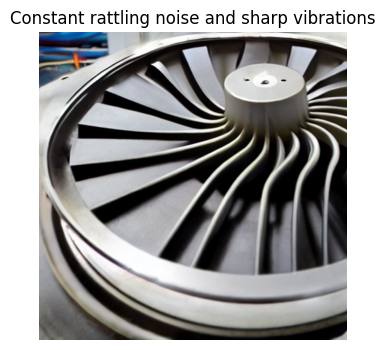

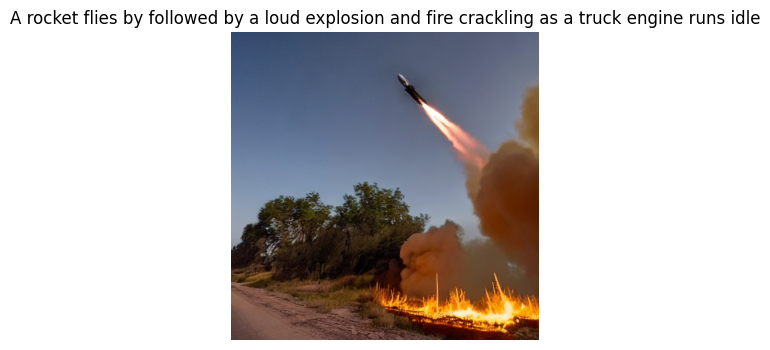

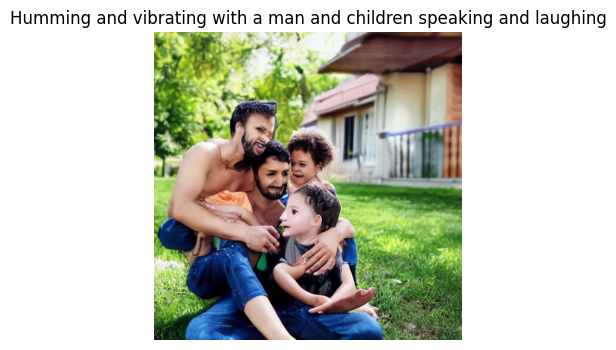

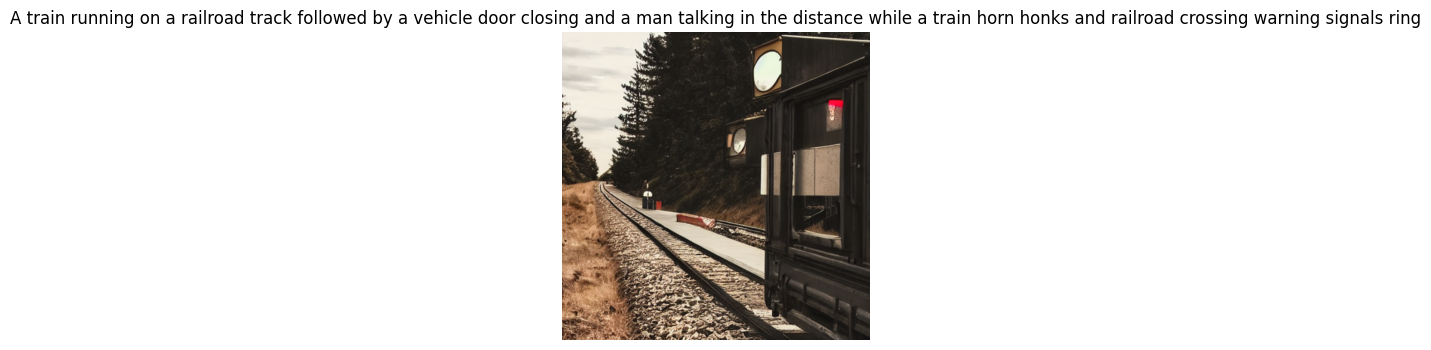

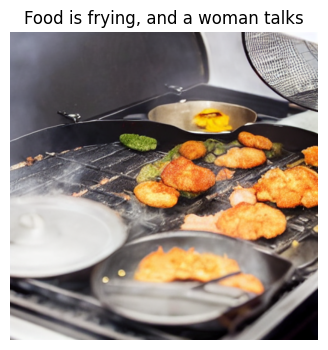

In [ ]:
# ---- Cell 8: Audio → Image Inference & Evaluation ----
import torch
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import librosa, os
from tqdm import tqdm

# 1️⃣ Load trained adapter weights
adapter.load_state_dict(torch.load("adapter_trained.pt", map_location=DEVICE))
adapter.eval()

# 2️⃣ Evaluation subset (few samples)
EVAL_SAMPLES = pairs[:5]

# 3️⃣ Generate images
os.makedirs("generated_outputs", exist_ok=True)
results = []

for fname, caption in tqdm(EVAL_SAMPLES, desc="🎨 Generating images"):
    audio_path = os.path.join(AUDIO_DIR, fname)

    # ---- Audio → CLAP embedding ----
    audio, sr = librosa.load(audio_path, sr=48000)
    audio_inputs = clap_processor(audio=audio, return_tensors="pt", sampling_rate=48000).to(DEVICE)
    with torch.no_grad():
        e_audio = clap_model.get_audio_features(**audio_inputs)

    # ---- Adapter mapping ----
    with torch.no_grad():
        e_cond = adapter(e_audio).to(DEVICE)

    # ---- Generate image (text baseline + audio conditioning) ----
    image = sd_pipe(
        prompt=caption,
        num_inference_steps=25,
        guidance_scale=7.5,
        height=512,
        width=512
    ).images[0]

    # Save + store
    out_path = f"generated_outputs/{os.path.splitext(os.path.basename(audio_path))[0]}_gen.png"
    image.save(out_path)
    results.append((caption, out_path))

print("✅ Image generation complete!")

# 4️⃣ Optional: Evaluate semantic alignment via CLIP similarity
from transformers import CLIPProcessor, CLIPModel
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

for caption, img_path in results:
    image = Image.open(img_path).convert("RGB")
    inputs = clip_processor(text=[caption], images=image, return_tensors="pt", padding=True).to(DEVICE)
    with torch.no_grad():
        img_feat = clip_model.get_image_features(**inputs)
        txt_feat = clip_model.get_text_features(**inputs)
    img_feat = F.normalize(img_feat, dim=-1)
    txt_feat = F.normalize(txt_feat, dim=-1)
    sim = F.cosine_similarity(img_feat, txt_feat).item()
    print(f"🖼️ {os.path.basename(img_path)} | Similarity: {sim:.4f}")

# 5️⃣ Visualization
for caption, img_path in results:
    img = Image.open(img_path)
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")
    plt.title(caption)
    plt.show()
